# Breast Cancer Challenge 

### Problem Summary
The goal of this challenge was to build a model capable of correctly identifying whether a breast cell is benign or malignant based on its measured attributes. 

Thus, the data science problem is binary classification. Cells can be either class 2 or 4 (which in the cancer grading system corresponds to benign or malignant - classes 1 (also benign) and 3 (local malignancy) are absent). 

One important consideration for this problem is that simple accuracy is likely not the best metric for evaluating the predictive model's capabilities. In a healthcare setting it is likely that false negatives (e.g. incorrectly classifying malignant cells as benign) are significantly worse than false positives (classifying benign cells as malignant) since the former could result in untreated cancer. The impact of this choice to optimize for recall is highlighted in the Discussion section.

This notebook is organized into sections as follows:
1. Data exploration
2. Modeling - logistic regression
3. Hyperparameter tuning
4. Discussion
5. Conclusion

In [18]:
# imports used for this challenge
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sklearn.linear_model as sklm
import sklearn.model_selection as skms
import sklearn.ensemble as sken
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler
import itertools

In [2]:
# set some globals, parameters
sns.set_style("darkgrid")

# also define a confusion matrix function
# citation: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html (BSD License)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)

### Data exploration
Here, we:
* Read in data and do basic tests to understand how the data are organized
* Look for missing data
* Evaluate class imbalances 
* Investigate feature correlations

First, we can read in the data, assigning column names as described in the documentation.

In [3]:
colnames = ['ID', 'Clump Thickness', 'Size Uniformity', 'Shape Uniformity', 'Marginal Adhesion', 'Epithelial Size',
         'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']
cell_features_classes = pd.read_csv('breast-cancer-wisconsin.csv', header=None, names=colnames, index_col=0)
cell_features_classes.head()

,Clump Thickness,Size Uniformity,Shape Uniformity,Marginal Adhesion,Epithelial Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
ID,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2


From the above, we can see that indeed the features are discretized. Now let's see how the features are distributed - i.e. do some features only take on certain values between 1 and 10? Also, let's double check to make sure the column dtypes are what they appear to be. 

In [4]:
for featurename in colnames[1:]:
    unique_values = sorted(list(cell_features_classes[featurename].unique()))
    print(featurename+' unique values: ', unique_values, cell_features_classes[featurename].dtype)

Clump Thickness unique values:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] int64
Size Uniformity unique values:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] int64
Shape Uniformity unique values:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] int64
Marginal Adhesion unique values:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] int64
Epithelial Size unique values:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] int64
Bare Nuclei unique values:  ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', '?'] object
Bland Chromatin unique values:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] int64
Normal Nucleoli unique values:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] int64
Mitoses unique values:  [1, 2, 3, 4, 5, 6, 7, 8, 10] int64
Class unique values:  [2, 4] int64


Aha! While it appears that features do span the entire possible range of values, we can see that the Bare Nuclei column actually has some unknown values which were input as '?'

First, let's see what classes unknown bare nuclei come from (for example, maybe all '?' values correspond to malignant cells). 

In [5]:
unknown_nuclei_classes = cell_features_classes[cell_features_classes['Bare Nuclei']=='?']['Class']
print('The classes of unknown nuclei are \n', unknown_nuclei_classes)

The classes of unknown nuclei are 
 ID
1057013    4
1096800    2
1183246    2
1184840    2
1193683    2
1197510    2
1241232    2
169356     2
432809     2
563649     4
606140     2
61634      2
704168     2
733639     2
1238464    2
1057067    2
Name: Class, dtype: int64


It looks like there is a mix, so maybe this '?' category is due to poor microscope images, etc. Since there are only 16 unknown values, let's just remove them from the sample.

In [6]:
cleaned_features_classes = cell_features_classes.replace('?', np.NaN).dropna()
cleaned_features_classes = cleaned_features_classes.astype({'Bare Nuclei':'int64'})

With the features cleaned, we can recast the classes as being 0 (for benign) and 1 (for malignant). Thus our classes have been intuitively mapped to positive class for malignant, negative for benign. This makes the process of model evaluation a little more convenient down the road and we can always map our predictions back to the real tumor class values.

In [7]:
cleaned_features_classes.Class.replace([2, 4], [0, 1], inplace=True)

 Now we can take a look at the cleaned data:

In [8]:
cleaned_features_classes.describe()

,Clump Thickness,Size Uniformity,Shape Uniformity,Marginal Adhesion,Epithelial Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,0.349927
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.477296
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


A few observations:
* Since we removed some entries, there are now 683 cells with complete data
* The classes appear to be imbalanced, since the mean class is 0.35 instead of 0.5 as expected for balanced classes.
* The features are also not evenly distributed across the possible dynamic range - all features have means well below the 5.5 expected for an even distribution.
* In particular the Mitoses column has many low values - since mitoses refers to cell division this could just mean that most cells are not undergoing mitoses.

Just to confirm what can be seen in the above table, let's see how unbalanced the classes are:

In [9]:
benign_fraction = (cleaned_features_classes[cleaned_features_classes['Class']==0].count()[0]) \
                    / cleaned_features_classes['Class'].count()
print('The fraction of cells that are benign is:', round(benign_fraction, 2))

The fraction of cells that are benign is: 0.65


So about 2:1 in favor of benign cells. This isn't so unbalanced that we can't simply adjust class weights during model training. 

As a final bit of exploratory analysis, let's see how correlated the features are with one another and with the target classes.

([<matplotlib.axis.YTick at 0x1a1cd03ef0>,
 <a list of 10 Text yticklabel objects>)

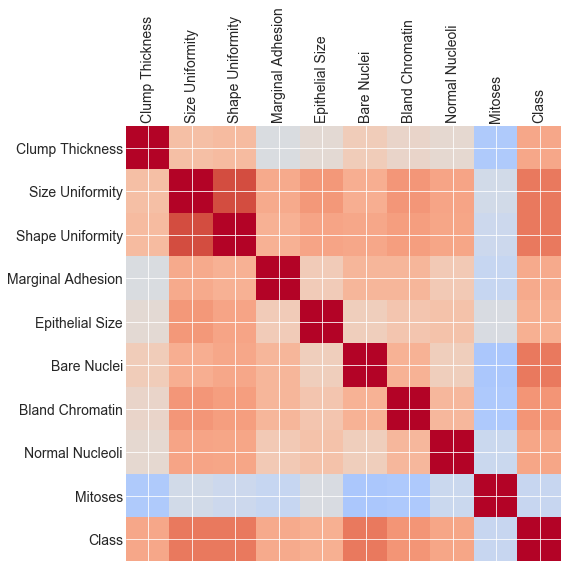

In [10]:
feature_correlations = cleaned_features_classes[colnames[1:]].corr()

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(feature_correlations,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(feature_correlations.columns)), feature_correlations.columns, rotation='vertical', fontsize=14)
plt.yticks(range(len(feature_correlations.columns)), feature_correlations.columns, fontsize=14)

Looking at the correlation matrix, we can see a few things:
* As expected by the fact that Mitoses is generally 1, it doesn't strongly correlate with anything
* Class is correlated with the rest of the features
* Some features are highly correlated - for example Size/Shape Uniformity are correlated. 

### Modeling - Logistic Regression

To briefly summarize key insights from the data exploratoration:
* After cleaning, data is complete for 683 cells - a small number of cells were ignored due to unknown entries
* Features are somewhat biased towards low values but span the entire range of possible values
* Classes are slightly imbalanced 2:1 in favor of benign samples
* Some features are correlated with one another
* The feature set is correlated with the classification, indicating meaningful features

As this is binary classification, (multivariate) logistic regression is a good first algorithm. As an added bonus this algorithm avoids having decorrelate our data (which we would want to do if we were to use, e.g., naive Bayes).  

First things first - let's split the data into training and test sets (75/25 split - this leaves about 150 cells as a test set). We stratify the split to ensure the fractions of malignant tumors are the same in the test split as the overall set. Features are scaled as they are split - feature scaling is important for some regularization methods (e.g. ridge). 

In [11]:
X_train, X_test, y_train, y_test = skms.train_test_split(StandardScaler().fit_transform(
    cleaned_features_classes[colnames[1:10]]), cleaned_features_classes[colnames[-1]], test_size=0.25, 
    stratify=cleaned_features_classes[colnames[-1]])

Now, we can do a basic regression using default sklearn parameters (ridge regularization, unit regularization weight). Note that here and below the classes are set to be balanced.

As discussed in the introduction, **the metric used to assess model performance is recall**, since we want to minimize the number of malignant cells falsely identified as benign. 

In [12]:
basic_logmodel = sklm.LogisticRegression(class_weight='balanced')
basic_logmodel.fit(X_train, y_train)

basic_results = basic_logmodel.predict(X_test)

basic_recall = recall_score(y_test, basic_results)
print('Off-the-shelf logistic model recall:', round(basic_recall, 5))


Off-the-shelf logistic model recall: 0.96667


### Hyperparameter Tuning

In reality, though, we want to tune the regression hyperparameters rather than use the defaults. This can be done using sklearn's randomizedsearchcv. In particular we are interested in tuning:
* The choice of cost function (L1/lasso or L2/ridge)
* The regularization strength (given as k = 1/lambda)
* The intercept scaling (coefficient controls how strongly regularization is applied to the intercept term)

We use 10-fold cross-validation, 3000 iterations, and store the best parameters.

Note again that the scoring method to select the best hyperparameters is recall, i.e. we want to minimize the number of false negatives, because incorrectly identifying a malignant cell as benign is much worse than identifying a benign cell as malignant. 

In [13]:
# define the model to cross-validate
cell_xvalmodel = sklm.LogisticRegression(class_weight='balanced')

# define the hyperparameter ranges
penalties = ['l1', 'l2']
k_range = np.arange(0.01, 1.5, 0.025)
intercept_range = np.arange(0.01, 1.5, 0.025)
hyperparameters = dict(penalty=penalties, C=k_range, intercept_scaling=intercept_range)

# now run the cross-validation
crossval = skms.RandomizedSearchCV(cell_xvalmodel, hyperparameters, n_iter=3000,
                                   cv=10, refit='recall_score', n_jobs=-1, verbose=0)
best_model = crossval.fit(X_train, y_train)

# return the best parameters
best_penalty = best_model.best_estimator_.get_params()['penalty']
best_k = best_model.best_estimator_.get_params()['C']
best_intercept = best_model.best_estimator_.get_params()['intercept_scaling']
print('best penalty, k, and intercept scaling:', best_penalty, round(best_k, 2), round(best_intercept,2))

best penalty, k, and intercept scaling: l2 0.66 0.08


With the best hyperparameters, we can now run the model on the holdout set to retrieve test predictions. 

In [14]:
tuned_results = best_model.predict(X_test)

tuned_recall = recall_score(y_test, tuned_results)
print('Tuned logistic model recall:', round(tuned_recall, 5))

Tuned logistic model recall: 0.98333


Nice! Our recall score improved over the default model. 

### Discussion
Let's dive a little deeper into the results - we can plot a confusion matrix to get some insight into how the tuned model performs. Of particular interest is the upper right hand portion of the matrix - this indicates the false negatives, which we want to avoid. 

Normalized confusion matrix
[[0.98333333 0.01666667]
 [0.03603604 0.96396396]]


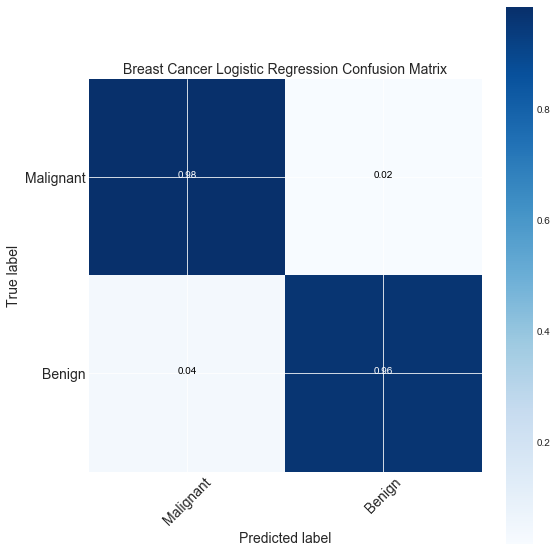

In [17]:
confusion_mat = confusion_matrix(y_test, tuned_results, labels=[1, 0])

plt.figure(figsize=(8,8))

plot_confusion_matrix(confusion_mat, classes=['Malignant', 'Benign'], normalize=True,
                      title='Breast Cancer Logistic Regression Confusion Matrix')

plt.show()


Because the hyperparameters were optimized for recall, it is expected that precision suffers - i.e. we chose to minimize false negatives at the expense of increasing false positives. In a healthcare setting this would seem to be a worthwhile tradeoff. 

### Conclusion

The logistic regression model I implemented achieves >95% success in identifying truly malignant breast cells. This was achieved while optimizing for recall in order to minimize the number of false negatives (malignant cells misclassified as benign). 

When using the approach detailed in this work in a healthcare setting, one possible improvement that could be made is to adjust the threshold used to classify a cell as benign/malignant. For example, if a hospital knew they wanted to achieve a false negative rate of <1%, then during cross-validation the decision boundary could be adjusted in order to reduce the false negative rate (at the expense of more false positives).  

Another possible area for improvement is model selection. Since the features are discretized, a tree-based model may be another good choice. I did try a random forest classifier initially in addition to logistic regression, but the logistic regression classifier gave better results by default, so I chose to pursue the latter. With more time and depending on how important it is to improve performance, it may be worth it to comprehensively explore other models.



